# Онлайн-стажировка СБЕР

Практикант: Шагвлаеев Рамиль Рафисович

Почта: shagvaly@yandex.ru

Telegram/GitHub: @shahva1y

### Описание задачи

В файле data.csv (находится в архиве "Вспомогательный данные") представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

Например, если бы мы знали будущее объема расчетных счетов, как на рисунке ниже, то стабильная часть на 1 месяц (1м) была бы на уровне, обозначенным красным цветом. Это тот уровень, который не пробивается на протяжении 1 месяца. Аналогично 2м – зеленый, 3м – синий, 4м – розовый.

<center><img src="./image.png" width="70%"></center>

Для временного ряда в файле data.csv необходимо построить модель, которая оценивает обьем стабильной части средств на дату.

Нужно одновременно минимизировать величины:

* максимальный объем пробития стабильный части на валидационной выборке 
* фактическая стабильная часть – модельная стабильная часть 

### Предварительная обработка данных

Импортируем библеотеки.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

import datetime

In [2]:
warnings.filterwarnings('ignore')

Импортируем данные из csv-файла.

In [3]:
data = pd.read_csv('./data.csv', delimiter=';')

In [4]:
data.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


In [5]:
data.shape

(2111, 2)

Проверим данные на наличие пропущенных значений.

In [6]:
data.isna().sum()

REPORTDATE    0
VALUE         0
dtype: int64

Пропущенных значений нет.

Для удобства обработки приведем колонку данных "REPORTDATE" к формату datetime. 

In [7]:
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['REPORTDATE'], infer_datetime_format=True)

Визуализируем полученные данные.

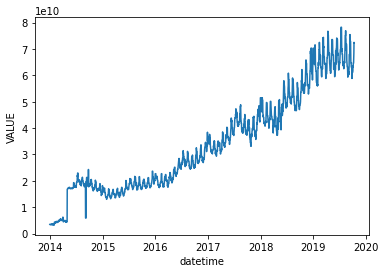

In [8]:
sns.lineplot(data=df, x='datetime', y='VALUE')
plt.show()

График имеет ряд особенностей. 

1. Представленная зависимость выражена положительным трендом.

2. Можно заменить, что на промежутке с 2014 г. по 2015 г. временной ряд изменяет свой характер поведения. Причинами этого могут быть различные факторы, можно лишь выделить один из них - [валютный кризис](https://ru.wikipedia.org/wiki/Валютный_кризис_в_России_(2014—2015)). Таким образом, мы будем рассматривать данные только от начала 2015 года.

3. Временной ряд с 2015 года имеет выраженный гетероскедастичный характер. С увеличением времени наблюдения увеличивается и разбос значений, что говорит о мультипликативности сезонных поправок.

Пролагарифмируем наши значения.

In [9]:
df['ln'] = np.log(df['VALUE'])

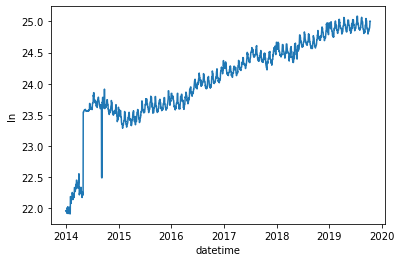

In [10]:
sns.lineplot(data=df, x='datetime', y='ln')
plt.show()

In [11]:
df = df[df['datetime'] >= '2015-01-01']

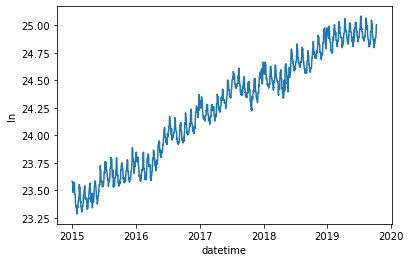

In [12]:
sns.lineplot(data=df, x='datetime', y='ln')
plt.show()

### Модель 

Для предсказания наших данных будем использовать модель квантильной регрессии. 

Следуя статье [[1]](https://peerj.com/preprints/3190/) мы будет предполагать, что модель нашего временного ряда состоит из следующих составляющих:

* $T(t)$ - трендовая, моделирует непериодические изменения значения временного ряда. Определяет тенденция изменения уровня значений.

* $S(t)$ - сезонная, представляет периодические изменения (например, еженедельную и годовую сезонность)

* $\epsilon_{t}$ - ошибка, случайная непрогнозируемая компонента временного ряда. Представялет собой изменения, которые не учитываются моделью.

Такием образом, логарифмированные наши данные, выражаются уравнием ниже. 

$y_{t} = T(t)*S(t)*\epsilon_{t}$

$ln(y_{t}) = ln(T(t)*S(t)*\epsilon_{t})$

$ln(y_{t}) = lnT(t) + lnS(t) + ln\epsilon_{t}$

#### Трендовая составляющая



Будем аппроксимировать нашу трендовую составляющую квадратичной по времени зависимостью. Поскольку текущие представления времени 'datetime' и 'REPORTDATE' не подходят для данной задачи, переведем их в относительные единицы времени, измеряя количество дней прошедших с начала измерений (1 января 2015 года). 

In [13]:
import datetime

df['time'] = df['datetime'].apply(lambda time: (time - df['datetime'].iloc[0]).days)

In [14]:
df.head()

,REPORTDATE,VALUE,datetime,ln,time
367,01.01.2015,17452425921,2015-01-01,23.582744,0
368,02.01.2015,17452425921,2015-01-02,23.582744,1
369,03.01.2015,17452425921,2015-01-03,23.582744,2
370,04.01.2015,17452425921,2015-01-04,23.582744,3
371,05.01.2015,16162817600,2015-01-05,23.505979,4


# Сезонная составляющая
Сезонные колебания определяются характерным временем колебаний - периодом. Интуитивно можно выделить следующие временные отрезки: неделя, месяц, квартал, ..., год, ...

Посмотрим на наши данные в разрезе одного года. Для этого выразим наш временной ряд через 'годовые дни'. 1 янвяря - первый день в году соответсвует 1 день. Последний день - 365.

In [15]:
df['day_of_year'] = df['datetime'].dt.dayofyear
df['year'] = df['datetime'].dt.year

In [16]:
df.head()

,REPORTDATE,VALUE,datetime,ln,time,day_of_year,year
367,01.01.2015,17452425921,2015-01-01,23.582744,0,1,2015
368,02.01.2015,17452425921,2015-01-02,23.582744,1,2,2015
369,03.01.2015,17452425921,2015-01-03,23.582744,2,3,2015
370,04.01.2015,17452425921,2015-01-04,23.582744,3,4,2015
371,05.01.2015,16162817600,2015-01-05,23.505979,4,5,2015


Ниже представлен график зависимостей логарифмированной целевой переменной от времени, выраженной в днях. Каждый цвет соответсвует определенному году. 

Можно заметить периодические колебания. Количество пиков внутри одного года равно 12, что может свидетельствать о месячной периодичности временного ряда.

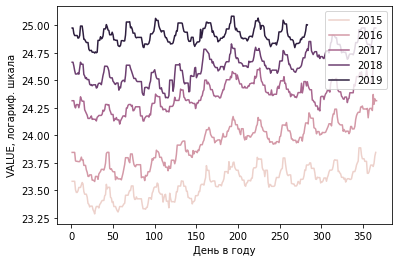

In [17]:
p = sns.lineplot(x="day_of_year", y="ln", hue="year", data=df)
p.legend(loc='upper right')
p.set_ylabel("VALUE, логариф. шкала")
p.set_xlabel("День в году")
plt.show()

Подобные периодические колебания хорошо описываются функциями времени синуса и косинуса.

Однако искать периоды сезонных поправок визуально весьма сложная задача. Поэтому для определения всех возможных (видимых и невидимых глазом) сезонных компонент, будем предполагать их наличие с периодами 365.25/12, 365.25/4, 365.25/2, 365.25/1. Данные периоды соответсвуют месячной, квартальной, полугодовой, годовой сезонностям.

Для этого мы сгенерируем дополнительные признаки, соответсвующие разным периодам колебаний (частотам). Это будет соответствовать прибжиженному разложению в ряд Фурье.

Преобразования производятся по следующим формулам:
$$x_{sin} = sin\left(\frac{2\cdot\mathrm{\pi} \cdot \mathrm{t}}{ \mathrm{T} }\right)$$ 
$$x_{cos} = cos\left(\frac{2\cdot\mathrm{\pi} \cdot \mathrm{t}}{ \mathrm{T} }\right)$$ 

Здесь t - это значение момента времени, а T - значение временного периода в единицах измерения времени.

Нужно отметить, что сезонными изменениями с периодами больше года мы пренебрегаем. Преполагая, что их вклады на отрезках времени менеше года - постоянны, а на отрезках больше года зависимость определяются трендовой составляющей.

Перейдем к обучению модели.

### Обучение

Для разработки регрессора воспользуемся библеотекой с иструментами машинного обучения [statmodels](https://www.statsmodels.org/stable/index.html).

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as fsm

fsm.quantreg поможет подобрать коэффициенты для квантильной регрессии. Но перед ее использованием нужно записать выражение, определяющее целевую переменную и признаки по которым мы будем эту переменную предсказывать.

In [19]:
relation = 'ln ~ '

#трендовые поправки
relation += 'time + I(time ** 2)'

#сезонные поправки
for x in [1, 2, 4, 12]:
    relation += (' + I(np.sin(2*math.pi*time*'+ str(x) +'/365.25))' + 
                 ' + I(np.cos(2*math.pi*time*'+ str(x) +'/365.25))')

В качестве обучающей выборки возьмем все доступные данные, кроме последнего года.

In [20]:
model = fsm.quantreg(relation, data=df.drop(['REPORTDATE', 'VALUE', 'datetime', 'day_of_year', 'year'], axis=1)[:-365])

Поскольку нашей задачей является определения нижнего порога, в качетсве квантиля возьмем значение равное 0.1. Тем самым минимизируется максимальный объем пробития стабильный части на выборке.

In [21]:
res = model.fit(q=0.1)

### Предсказание

Модель обучена. Предскажем значения для оставшихся 365 дней. Необходимые значения коэффициентов можно найти в атрибуте res.params. Расчитаем какие значения предсказывает наша модель для тестовой выборки.

In [22]:
res.params

Intercept                                      2.326943e+01
time                                           1.217714e-03
I(time ** 2)                                  -1.714999e-07
I(np.sin(2 * math.pi * time * 1 / 365.25))    -5.123174e-02
I(np.cos(2 * math.pi * time * 1 / 365.25))    -4.629157e-02
I(np.sin(2 * math.pi * time * 2 / 365.25))     1.834823e-03
I(np.cos(2 * math.pi * time * 2 / 365.25))     5.291056e-02
I(np.sin(2 * math.pi * time * 4 / 365.25))    -2.581497e-03
I(np.cos(2 * math.pi * time * 4 / 365.25))     1.561394e-02
I(np.sin(2 * math.pi * time * 12 / 365.25))    6.313617e-02
I(np.cos(2 * math.pi * time * 12 / 365.25))   -3.430482e-02
dtype: float64

In [23]:
y_pred = res.params['Intercept'] + res.params['time'] * df['time'] + res.params['I(time ** 2)'] * (df['time'] ** 2)
for x in [1, 2, 4, 12]:
    y_pred += (res.params['I(np.sin(2 * math.pi * time * '+ str(x) +' / 365.25))'] * np.sin(2*math.pi*df['time']*x/365.25) +
               res.params['I(np.cos(2 * math.pi * time * '+ str(x) +' / 365.25))'] * np.cos(2*math.pi*df['time']*x/365.25))

Визуализируем полученные данные вместе с реальными данными.

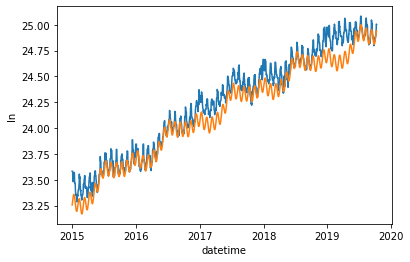

In [24]:
sns.lineplot(x=df['datetime'], y=df['ln'])
sns.lineplot(x=df['datetime'], y=y_pred)
plt.show()

In [25]:
from statsmodels.tools.eval_measures import mse, rmse

print('MSE:', mse(df['ln'][-365:], y_pred[-365:]))
print('RMSE:', rmse(df['ln'][-365:], y_pred[-365:]))

MSE: 0.029114081697457137
RMSE: 0.17062849028652025


Тем не менее, указанная выше модель может иметь ряд недостатков.

Во-первых, квадратичная по времени трендовая составляющая может изменяться с течением времени. Это может быть вызвано общими экономическими факторами, так и ограниченностью объемов средств. Денег не бесконечно много, и в перспективе, должен наблюдаться эффект насыщения.

Во-вторых, ипользовать весь объем исторических данных не выгодно с точки зрения потребления ресурсов памяти.

Связи с этим предлагается упрощение в испорльзовании модели. Модель будет обновлять коэффициенты сгенерированных признаках используя данные за прошедшие 4 года.

### Функция model_forecast()

Прототип функции выгядит следующим образом: 

***model_forecast(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М***

Ниже представлена одна из реализаций этой функции.

In [26]:
from dateutil.relativedelta import relativedelta

def data_preprocessing(data):
    data['datetime'] = pd.to_datetime(data['REPORTDATE'], format="%d.%m.%Y")
    data['ln'] = np.log(df['VALUE'])
    
    return data

def model_train(data):
    relation = 'ln ~ '
    #трендовые поправки T(t)
    relation += 'time + I(time ** 2)'
    #сезонные поправки S(t)
    for x in [1, 2, 4, 12]:
        relation += (' + I(np.sin(2*math.pi*time*'+ str(x) +'/365.25))' + 
                     ' + I(np.cos(2*math.pi*time*'+ str(x) +'/365.25))')
    model = fsm.quantreg(relation, data=data)
    
    return model.fit(q=0.1)
    
def model_prediction(data, res):
    y_pred = res.params['Intercept'] + res.params['time'] * data['time'] + res.params['I(time ** 2)'] * (data['time'] ** 2)
    for x in [1, 2, 4, 12]:
        y_pred += (res.params['I(np.sin(2 * math.pi * time * '+ str(x) +' / 365.25))'] * np.sin(2*math.pi*data['time']*x/365.25) +
                   res.params['I(np.cos(2 * math.pi * time * '+ str(x) +' / 365.25))'] * np.cos(2*math.pi*data['time']*x/365.25))
    data['ln'] = y_pred
    
    return data

def model_forecast(start, duration, history):
    data = data_preprocessing(history)
    
    #генерация дат в периоде с start до (start + duration)
    time_start = pd.to_datetime(start)
    time_end = time_start + relativedelta(months=int(duration[:-1]))
    data_pred = pd.DataFrame({'datetime': pd.date_range(start=time_start, end=time_end, freq='D')})
    data = pd.merge(data, data_pred, how='outer', on='datetime')
    
    #представление времени в относительных единицах измерения
    data['time'] = data['datetime'].apply(lambda time: (time - data['datetime'].iloc[0]).days)
    
    res = model_train(data[data['datetime'] < time_start].drop(['datetime'], axis=1))
    #предсказание
    data_pred = model_prediction(data[data['datetime'] >= time_start], res)
    return math.e ** data_pred['ln'].min()

In [27]:
demo = pd.DataFrame(data[['REPORTDATE', 'VALUE']][(data['datetime'] < '2019-02-01') & (data['datetime'] >= '2015-01-01')])

model_forecast('01.02.2019', '12M', demo)

47073612425.65231

In [28]:
data[['VALUE']][data['datetime'] > '2019-02-01'].min()

VALUE    58800081047
dtype: int64